In [19]:
# from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image

import os
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F






In [20]:
from transformers import ViTFeatureExtractor, ViTModel
import torchvision.transforms as transforms

In [4]:
from seq_loader import ValData, TrainData

train_dataset = ValData()
#load and display imaes from the dqtaloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

In [8]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224', size=640)


/Users/dennisbaumann/opt/anaconda3/envs/casar_env/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [32]:
def preprocess_with_heatmap(images, heatmaps):
    # Apply the feature extractor transformations to the images
    encoding = feature_extractor(images=images, return_tensors="pt")
    pixel_values = encoding.pixel_values

    # Apply the same transformations to the heatmaps
    # def transform_heatmap(image, size):
    #     transform = transforms.Compose([
    #         transforms.Resize(size),
    #         transforms.ToTensor()
    #     ])
    #     return transform(image)
    
    # transformed_heatmaps = torch.stack([transform_heatmap(hm, (640, 640)) for hm in heatmaps])
    
    return pixel_values#, transformed_heatmaps


In [40]:
model = ViTModel.from_pretrained('google/vit-base-patch16-224', add_pooling_layer=False)
def forward(pixel_values):
    outputs = model(pixel_values, output_attentions=True, interpolate_pos_encoding=True)

    attentions = outputs.attentions[-1] # we are only interested in the attention maps of the last layer
    nh = attentions.shape[1] # number of head
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    w_featmap = pixel_values.shape[-2] // model.config.patch_size
    h_featmap = pixel_values.shape[-1] // model.config.patch_size
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu()
    print(attentions.shape)
    mean_attention = torch.mean(attentions, dim=0)

    return mean_attention


In [63]:
def custom_attention_loss(attentions, heatmaps):
    print(attentions.max(), attentions.min())

    print(heatmaps.max(), heatmaps.min())
    assert attentions.shape == heatmaps.shape, "Attention maps and heatmaps must have the same shape."
    loss = F.mse_loss(attentions, heatmaps)
    return loss

torch.Size([1, 3, 360, 360])
torch.Size([1, 3, 360, 640])
torch.Size([1, 640, 640])
torch.Size([12, 640, 640])
tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
tensor(1.) tensor(0.)
tensor(0.0280, grad_fn=<MseLossBackward0>)


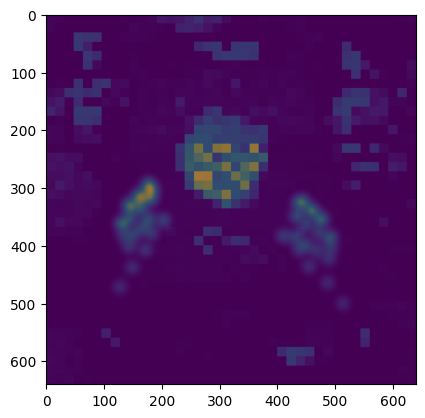

In [64]:
for batch in train_loader:
        img, hand_poses, label, obj_poses,heatmaps = batch
        images = img[:,:, 7, :, :]
        

        # Define the crop size
        crop_size = 360

        # Calculate the starting point for cropping
        start = (images.shape[-1] - crop_size) // 2

        # Crop the images
        cropped_images = images[:, :, :, start:start+crop_size]
        crop_size = 720
        start = (heatmaps.shape[-1] - crop_size) // 2
        heatmaps =  heatmaps[:,7, :, :]
        cropped_heatmaps = heatmaps[:, :, start:start+crop_size]
        cropped_heatmaps = cropped_heatmaps
        resized_heatmaps = nn.functional.interpolate(cropped_heatmaps.unsqueeze(1), size=(640, 640), mode='nearest').squeeze(1)
        # Convert to float
        resized_heatmaps = resized_heatmaps.float()

        # Normalize to [0, 1]
        resized_heatmaps = (resized_heatmaps - resized_heatmaps.min()) / (resized_heatmaps.max() - resized_heatmaps.min())
        
        # Print the shape of the cropped images
        print(cropped_images.shape)
        
        print(images.shape)
        print(resized_heatmaps.shape)
        # Preprocess images and heatmaps
        pixel_values = preprocess_with_heatmap(cropped_images, resized_heatmaps)
        
        # Get attention maps
        attention= forward(pixel_values)
        attention = attention.float()
        attention = (attention - attention.min()) / (attention.max() - attention.min())
        plt.imshow(attention.detach().numpy())
        plt.imshow(resized_heatmaps[0].detach().numpy(), alpha=0.5)
        # Compute custom attention loss
        loss = custom_attention_loss(attention, resized_heatmaps.squeeze(0))
        
        print(loss)
        break
        

torch.Size([1, 8, 720, 1280])
torch.Size([1, 720, 1280])
heatmape shape (3, 640, 640)


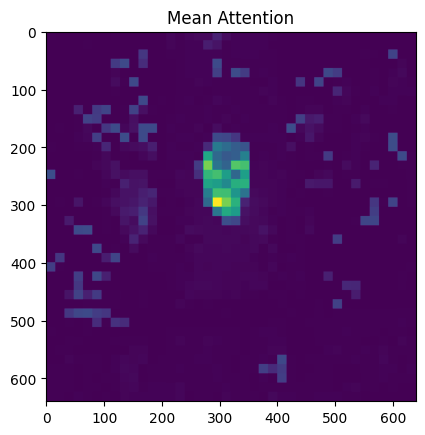

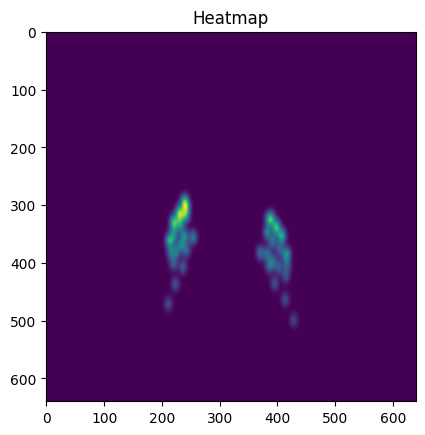

In [ ]:
for i, (img, hand_poses, label, obj_poses,heatmaps) in enumerate(train_loader):
    
    img = img[:,:, 7, :, :]
    print(heatmaps.shape)
    heatmap = heatmaps[:,7, :, :]
    print(heatmap.shape)
    heatmap_3channel = heatmap.repeat(3, 1, 1)
    pixel_values = feature_extractor(img)
    heatmap_values = feature_extractor(heatmap_3channel)
    attentions = forward(pixel_values)
    mean_attention, heatmap_gt = plot_att(pixel_values,heatmap_values,attentions,i)
    # Plot the mean attention
    plt.imshow(mean_attention)
    plt.title("Mean Attention")
    plt.show()

    # Plot the heatmap
    plt.imshow(heatmap_gt)
    plt.title("Heatmap")
    plt.show()
    if i == 0:
        break

torch.Size([1, 8, 720, 1280])
torch.Size([1, 720, 1280])
heatmape shape (3, 640, 640)


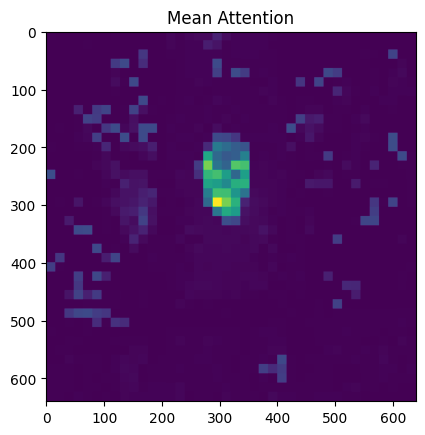

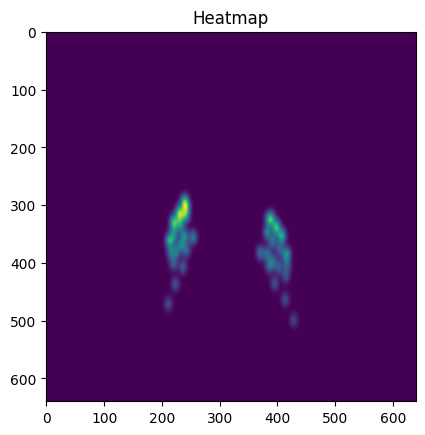

In [154]:
for i, (img, hand_poses, label, obj_poses,heatmaps) in enumerate(train_loader):
    
    img = img[:,:, 7, :, :]
    print(heatmaps.shape)
    heatmap = heatmaps[:,7, :, :]
    print(heatmap.shape)
    heatmap_3channel = heatmap.repeat(3, 1, 1)
    pixel_values = feature_extractor(img)
    heatmap_values = feature_extractor(heatmap_3channel)
    attentions = forward(pixel_values)
    mean_attention, heatmap_gt = plot_att(pixel_values,heatmap_values,attentions,i)
    # Plot the mean attention
    plt.imshow(mean_attention)
    plt.title("Mean Attention")
    plt.show()

    # Plot the heatmap
    plt.imshow(heatmap_gt)
    plt.title("Heatmap")
    plt.show()
    if i == 0:
        break

In [160]:
mean_attention = torch.tensor(mean_attention)
heatmap_gt = torch.tensor(heatmap_gt)

# Ensure they have the same shape
assert mean_attention.shape == heatmap_gt.shape
print(mean_attention.shape)
random = torch.tensor(np.ones((640,640)))
loss = nn.MSELoss()
print(loss(mean_attention, random))

torch.Size([640, 640])
tensor(0.9988, dtype=torch.float64)


/var/folders/v6/btqjmdm16h3f9ct3qk98prkm0000gn/T/ipykernel_62228/522964433.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_attention = torch.tensor(mean_attention)
/var/folders/v6/btqjmdm16h3f9ct3qk98prkm0000gn/T/ipykernel_62228/522964433.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  heatmap_gt = torch.tensor(heatmap_gt)


In [124]:
# from torchsummary import summary
from torchinfo import summary

summary(model, (1,3, 224, 224))


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [ViTEmbeddings: 1, ViTPatchEmbeddings: 2, Conv2d: 3, Dropout: 2, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5, ViTLayer: 3, LayerNorm: 4, ViTAttention: 4, ViTSelfAttention: 5, Linear: 6, Linear: 6, Linear: 6, Dropout: 6, ViTSelfOutput: 5, Linear: 6, Dropout: 6, LayerNorm: 4, ViTIntermediate: 4, Linear: 5, GELUActivation: 5, ViTOutput: 4, Linear: 5, Dropout: 5]

RGB
RGBA


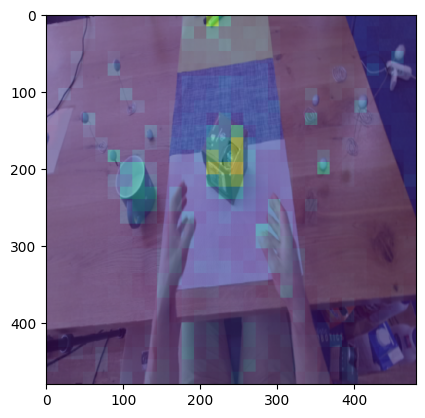

In [43]:
from PIL import Image

# Load the original image
original_image = Image.open('visuals/img.png')

# Load the mean attention image
mean_attention_image = Image.open('visuals/attn-headmean.png')

# Resize the mean attention image to match the size of the original image
mean_attention_image = mean_attention_image.resize(original_image.size)
print(original_image.mode)
print(mean_attention_image.mode)
mean_attention_image = mean_attention_image.convert(original_image.mode)

# Create a new image with the overlay
overlay_image = Image.blend(original_image, mean_attention_image, alpha=0.5)

# Display the overlay image
plt.imshow(overlay_image)
